In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
import os
import torch
import torchmetrics
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader, random_split
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

from PIL import Image

In [3]:
train_df = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test_df = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

train_df.shape, test_df.shape

((42000, 785), (28000, 784))

In [4]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Create Dataset

In [5]:
class CustomDataset(Dataset):
    def __init__(self, df, is_test=False):
        self.is_test = is_test
        if not self.is_test:
            self.labels = df['label']
            self.df = df.drop('label', axis=1)
        else: self.df = df
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        pixels = self.df.iloc[index].values.reshape((28, 28))
        img = Image.fromarray(pixels.astype('uint8'), mode='L')
        tensor_image = self.transform(img)
        if self.is_test:
            return tensor_image
        else:
            label = self.labels[index]
            return tensor_image, label

In [6]:
train_dataset = CustomDataset(train_df)
train_dataset.__getitem__(1)[0].shape

torch.Size([1, 28, 28])

# Divide Dataset and create DataLoaders

In [7]:
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size

train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])
len(train_dataset), len(valid_dataset)

(33600, 8400)

In [8]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# Plot a Batch

In [9]:
def imshow(img, title='', size=10):
    """Plot the image batch.
    """
    plt.figure(figsize=(size, size))
    plt.title(title)
    plt.imshow(np.transpose( img.numpy(), (1, 2, 0)), cmap='gray')
    plt.show()
    
def plot_one_batch(data):
    for i, data in enumerate(data):
        x, y = data
        print(len(x), len(y), y)
        imshow(torchvision.utils.make_grid(x, 4), title='Plot one Batch')
        break

32 32 tensor([5, 7, 9, 1, 0, 2, 8, 4, 3, 5, 4, 6, 9, 5, 1, 5, 7, 4, 8, 8, 1, 9, 9, 4,
        0, 6, 6, 1, 2, 8, 1, 6])


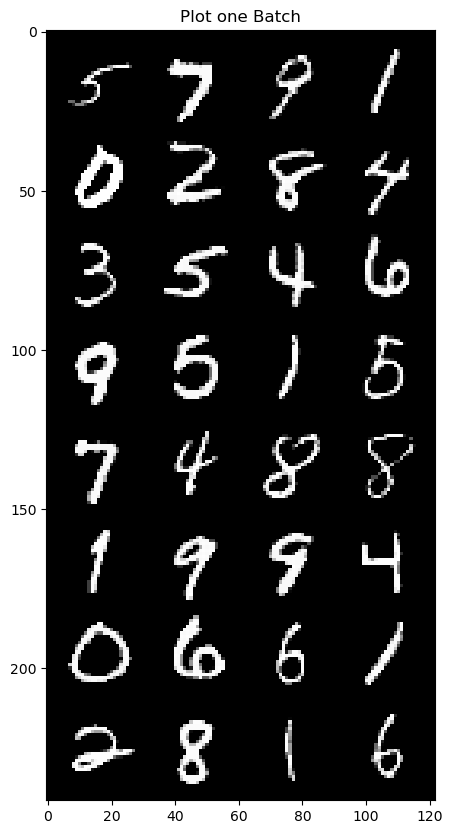

In [10]:
plot_one_batch(train_loader)

# Create our Model

In [11]:
class Model(pl.LightningModule):
    def __init__(self, learning_rate, batch_size):
        super().__init__()
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.train_accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=10)
        self.valid_accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=10)
        self.conv1 = nn.Sequential(nn.Conv2d(1, 32, 3), nn.ReLU(), nn.MaxPool2d(2, 2))
        self.conv2 = nn.Sequential(nn.Conv2d(32, 64, 3), nn.ReLU(), nn.MaxPool2d(2, 2))
        self.conv3 = nn.Sequential(nn.Conv2d(64, 128, 3), nn.ReLU(), nn.MaxPool2d(2, 2))
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Sequential(nn.Linear(128, 256), nn.ReLU(), nn.Linear(256, 128), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(128, 10))
        
    def train_dataloader(self):
        return DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(dataset=valid_dataset, batch_size=32, shuffle=False)
        
    def cross_entropy_loss(self, logits, labels):
        return nn.NLLLoss()(logits, labels)
        
    def training_step(self, batch, batch_idx):
        data, label = batch
        output = self.forward(data)
        loss = nn.CrossEntropyLoss()(output, label)
        self.log('train_loss', loss)
        self.train_accuracy(output, label)
        return {'loss': loss}
    
    def training_epoch_end(self, outs):
        self.log('train_acc_epoch', self.train_accuracy.compute())
        
    def validation_step(self, batch, batch_idx):
        val_data, val_label = batch
        val_output = self.forward(val_data)
        val_loss = self.cross_entropy_loss(val_output, val_label)
        self.log('val_loss', val_loss)
        self.valid_accuracy(val_output, val_label)
        
    def validation_epoch_end(self, outs):
        self.log('val_acc_epoch', self.valid_accuracy.compute())
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1) # Flatten
#         print(x.size()) 
        x = self.fc1(x)
        x = self.fc2(x)
        return x

## Find the best learning_rate

In [12]:
model = Model(batch_size=32, learning_rate=0.001)

trainer = pl.Trainer(gpus=1, auto_lr_find=True)

trainer.tune(model)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:479: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/loops/utilities.py:97: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  category=PossibleUserWarning,


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

{'lr_find': <pytorch_lightning.tuner.lr_finder._LRFinder at 0x766140b0ce50>}

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

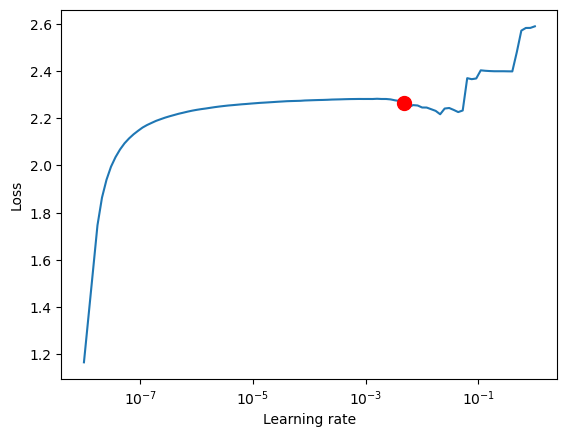

In [13]:
lr_finder = trainer.tuner.lr_find(model)

fig = lr_finder.plot(suggest=True)
fig.show()

In [14]:
lr_finder.suggestion()

0.00478630092322638

In [15]:
early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience = 3,
    strict = False,
    verbose = False,
    mode = 'min'
)

checkpoint_callback = ModelCheckpoint(
    monitor = 'val_loss',
    dirpath = '/kaggle/working/models/',
    filename = 'model-{epoch}-{val_loss:.2f}',
    save_top_k=3,
    mode='min'
)

In [16]:
model = Model(batch_size=32, learning_rate=lr_finder.suggestion())

trainer = pl.Trainer(
    gpus=1,
    max_epochs=10,
    callbacks=[early_stop, checkpoint_callback]
)

trainer.fit(model)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:479: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# Load model

In [17]:
pretrained_model = Model.load_from_checkpoint(batch_size=32, learning_rate=lr_finder.suggestion(), checkpoint_path=checkpoint_callback.best_model_path)
pretrained_model = pretrained_model.to('cuda')
pretrained_model.eval()
pretrained_model.freeze()

In [18]:
test_dataset = CustomDataset(test_df, is_test=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Make preds and get CSV

In [19]:
pretrained_model.eval()

preds = []

with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs.to('cuda')
        
        outputs = pretrained_model(inputs)
        _, batch_preds = torch.max(outputs, 1)
        batch_preds = batch_preds.cpu().numpy().tolist()
        preds.extend(batch_preds)

print(preds[:20])

[2, 0, 9, 9, 3, 7, 0, 3, 0, 3, 5, 7, 4, 0, 4, 3, 3, 1, 9, 0]


In [20]:
len(preds)

28000

In [21]:
sample_sub = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')
sample_sub.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [22]:
submission = pd.DataFrame({'ImageId':test_df.index+1, 'Label':preds})
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [23]:
submission.to_csv('submission.csv', index=False)